<a href="https://colab.research.google.com/github/prapar/Brain-MRI-Segmentation/blob/main/Brain_MRI_Segmentation_final_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
! pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
# import libraries
import pandas as pd
import numpy as np
import os
from google.colab import drive
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab.patches import cv2_imshow
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shutil
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
from segmentation_models import Linknet
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.applications.xception import Xception
from prettytable import PrettyTable
import os
from tensorflow.keras.models import model_from_json
import datetime
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import statistics

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [104]:
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'CaseStudy2')
drive.mount(MOUNTPOINT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [105]:
# Fetch data from kaggle
! mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/casestudy2/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download mateuszbuda/lgg-mri-segmentation
!unzip /content/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [106]:
path = os.getcwd()
print(path)

/content


In [107]:
# Read into dataframe
df_patient = pd.read_csv(path+'/lgg-mri-segmentation/kaggle_3m/data.csv')

# EDA on patient data

Though we would not use the above information on the patient and medical details of the tumor for our image segmentation problem, we can still do some analysis of the data to get a perspective of the condition given a patient.

In [108]:
print(df_patient.shape)
df_patient.head()

(110, 18)


,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [109]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

Data quality check

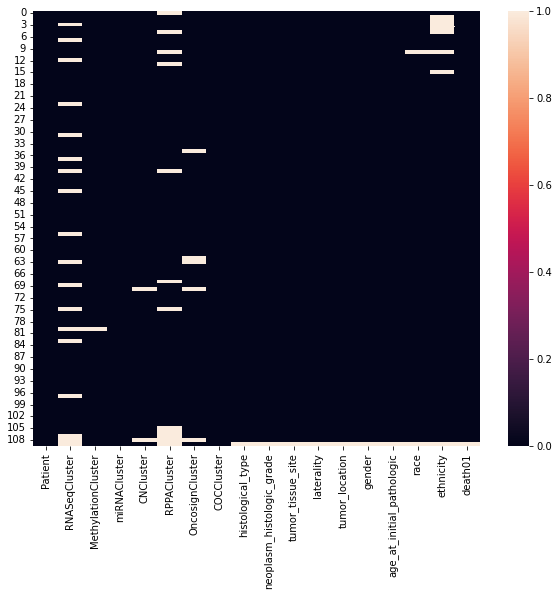

In [110]:
plt.subplots(figsize=(10,8))
sns.heatmap(df_patient.isnull())
plt.show()

There are some none values - possibly not applicable or not available. Let us check for any empty strings.

In [111]:
print(np.where(df_patient.applymap(lambda x : x =='\s+')))
print(np.where(df_patient.applymap(lambda x : x =='')))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


There seem to be no missing values.

In [112]:
df_patient['Patient'].nunique()

110

Patient column is the unique primary key for this table.

In [113]:
df_patient[df_patient['death01'].isnull()]

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
109,TCGA_HT_A61B,NaN,5.0,2,1.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


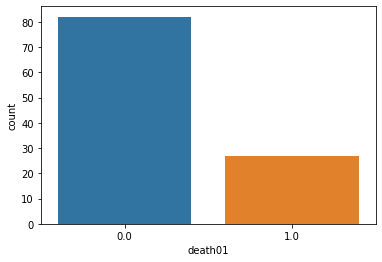

In [114]:
sns.countplot(x=df_patient['death01'])
plt.show()

In [115]:
len(df_patient[df_patient['death01']==1])/len(df_patient['death01'])

0.24545454545454545

About 25% of the patient records that we have, unfortunately have died. For one patient we do not have any information on this feature.

In [116]:
# Get a summary of Non numeric columns
objLst = list(df_patient.select_dtypes(exclude=['object']).columns.sort_values())
for col in objLst:
  print('***'+col+'***')
  print(df_patient[col].value_counts())
  print('-'*50)

***CNCluster***
1.0    59
3.0    29
2.0    20
Name: CNCluster, dtype: int64
--------------------------------------------------
***COCCluster***
1    56
3    30
2    24
Name: COCCluster, dtype: int64
--------------------------------------------------
***MethylationCluster***
5.0    37
3.0    34
4.0    21
2.0    13
1.0     4
Name: MethylationCluster, dtype: int64
--------------------------------------------------
***OncosignCluster***
2.0    58
1.0    29
3.0    18
Name: OncosignCluster, dtype: int64
--------------------------------------------------
***RNASeqCluster***
2.0    28
4.0    27
1.0    25
3.0    12
Name: RNASeqCluster, dtype: int64
--------------------------------------------------
***RPPACluster***
2.0    31
1.0    27
4.0    23
3.0    17
Name: RPPACluster, dtype: int64
--------------------------------------------------
***age_at_initial_pathologic***
53.0    5
51.0    5
29.0    5
33.0    4
39.0    4
43.0    4
54.0    4
58.0    4
62.0    4
49.0    4
67.0    3
70.0    3
38.0    

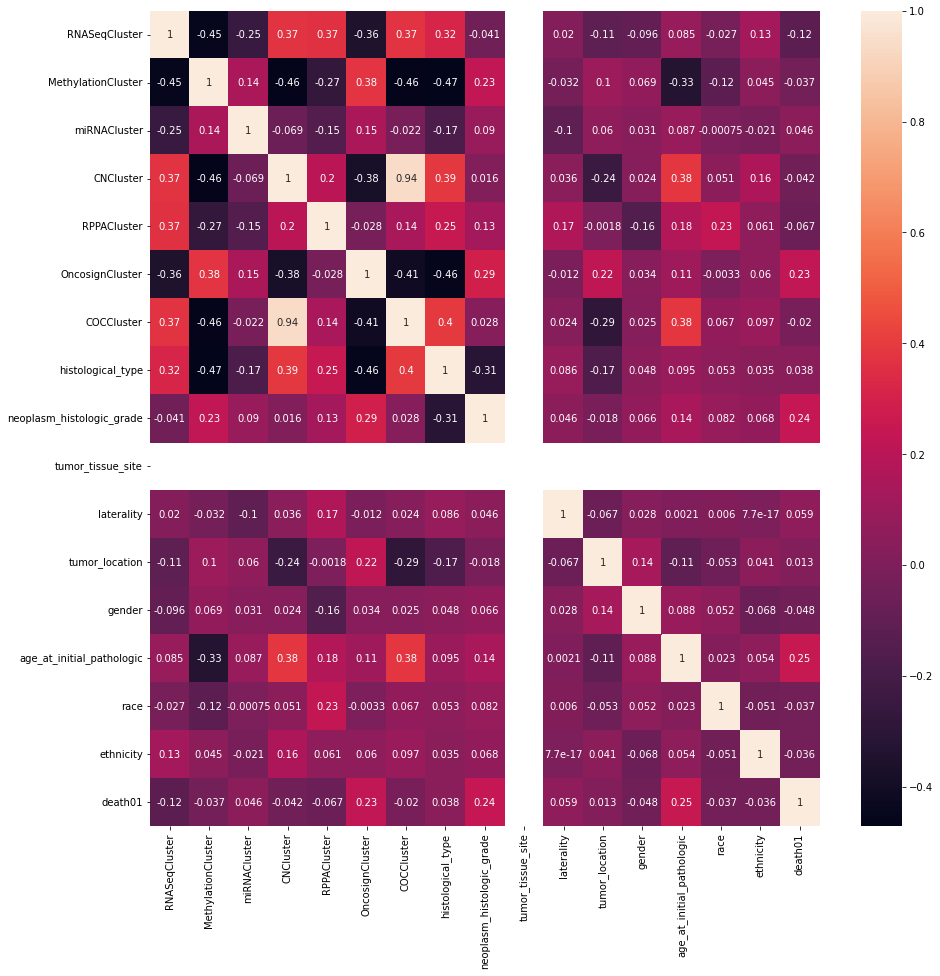

In [117]:
plt.subplots(figsize=(15,15))
sns.heatmap(df_patient.corr(), annot=True)
plt.show()

Age, neoplasm histologic grade and OncosignCluster seem to have the most correlation with the death of the patient. we will explore these further.

AGE

In [118]:
df_patient['age_at_initial_pathologic'].describe()

count    109.000000
mean      45.834862
std       13.797151
min       20.000000
25%       34.000000
50%       47.000000
75%       58.000000
max       75.000000
Name: age_at_initial_pathologic, dtype: float64

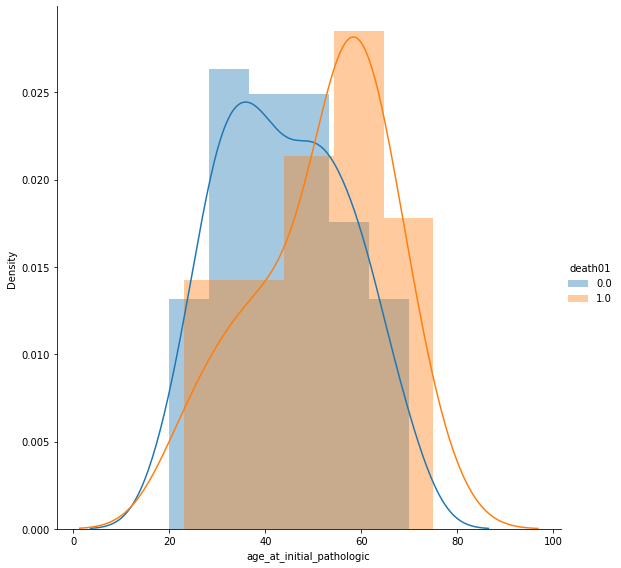

In [119]:
sns.FacetGrid(df_patient,hue='death01',height=8).map(sns.distplot,'age_at_initial_pathologic').add_legend()
plt.show()

Survival rates begin to decline from the age of 50. Death rate increases from there on.

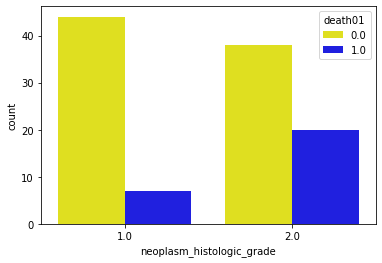

In [120]:
sns.countplot(x = 'neoplasm_histologic_grade', data = df_patient, hue = "death01", palette=['yellow','blue'])
plt.show()

Death rate is higher for neoplasm histologic grade 2. While survival rate is higher for grade 1.

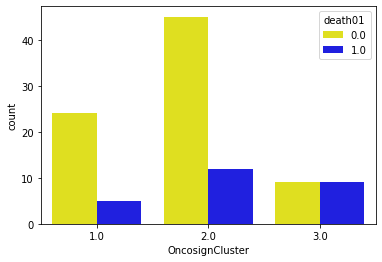

In [121]:
sns.countplot(x = 'OncosignCluster', data = df_patient, hue = "death01", palette=['yellow','blue'])
plt.show()

We can infer that survival rate is lowest for OncosignCluster category: 3.

GENDER

In [122]:
df_patient['gender'].value_counts()

1.0    56
2.0    53
Name: gender, dtype: int64

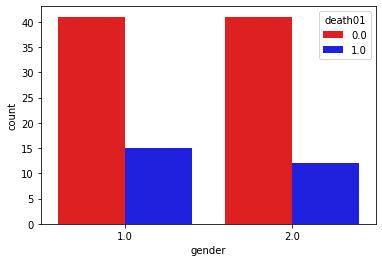

In [123]:
sns.countplot(x = 'gender', data = df_patient, hue = "death01", palette=['red','blue'])
plt.show()

Gender data seems to be more or less balanced. And gender doesnt seem to affect the death rates significantly.

RACE

In [124]:
df_patient['race'].value_counts()

3.0    98
2.0    10
Name: race, dtype: int64

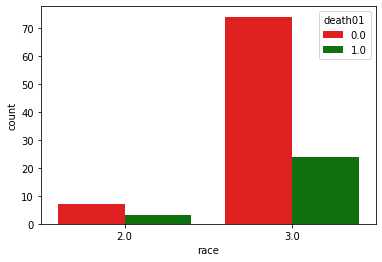

In [125]:
sns.countplot(x = 'race', data = df_patient, hue = "death01", palette=['red','green'])
plt.show()

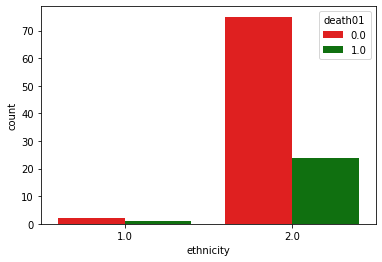

In [126]:
sns.countplot(x = 'ethnicity', data = df_patient, hue = "death01", palette=['red','green'])
plt.show()

The feature race has predominantly a race categorized as 3. Only 10 patients belong to race #2. Hence race is not very useful in understanding the survival rates or tumor details. This is also the case with ethnicity feature.

TUMOR SITE

In [127]:
df_patient['tumor_tissue_site'].value_counts()

1.0    109
Name: tumor_tissue_site, dtype: int64

In [128]:
df_patient[df_patient['age_at_initial_pathologic'].isnull()]

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
109,TCGA_HT_A61B,NaN,5.0,2,1.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The patient TCGA_HT_A61B	seems to have many Null valued features. Tumor Tissue Site is a single value for all customers ie 1.0. It doesnt give much information to understand the case better.

###Visualization using TSNE and KMeans Clustering.

Since we have many medical terms as features, let us try to use unsupervised learning techniques to see if the underlying data has a pattern showing the death events.

We'd impute the missing information using:
1. Mode for categorical features
2. Mean for the numerical 'age' feature.

In [129]:
# Impute missing values
feat_list = ['RNASeqCluster', 'MethylationCluster', 'miRNACluster',
       'CNCluster', 'RPPACluster', 'OncosignCluster', 'COCCluster',
       'histological_type', 'neoplasm_histologic_grade', 'tumor_tissue_site',
       'laterality', 'tumor_location', 'gender',
       'race', 'ethnicity','death01']
for feat in feat_list:
  freq = statistics.mode(df_patient[feat])
  df_patient.loc[df_patient[feat].isnull(),feat] = freq
avg = df_patient['age_at_initial_pathologic'].mean()
df_patient.loc[df_patient['age_at_initial_pathologic'].isnull(),'age_at_initial_pathologic'] = avg

In [132]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_patient.drop(columns=['Patient','death01'],axis=1))
print(X_tsne.shape)

(110, 2)


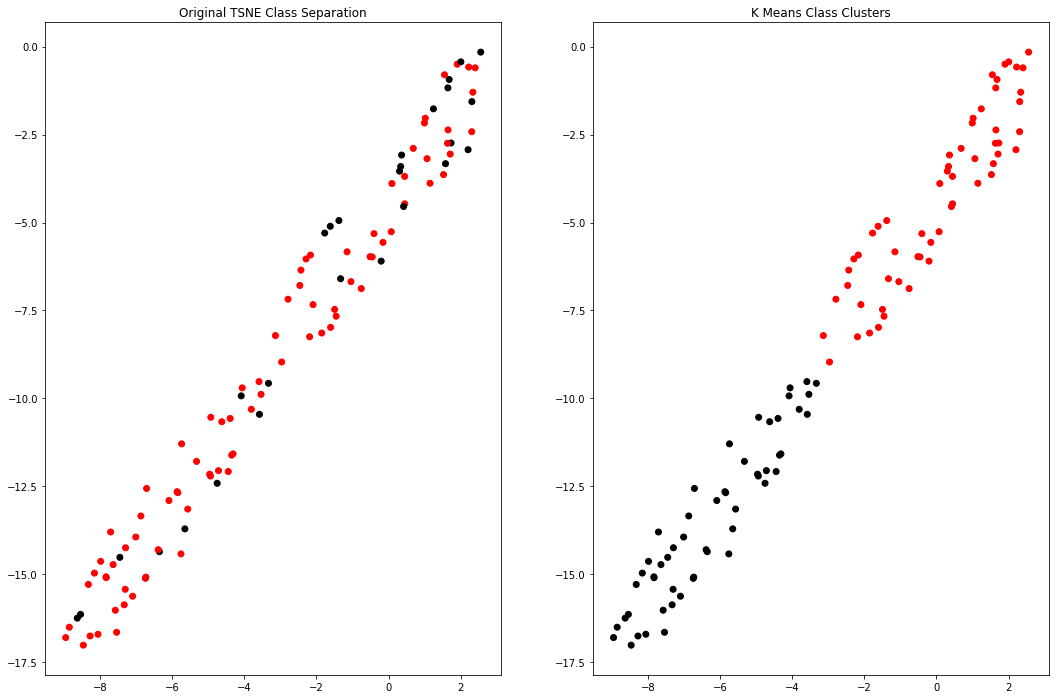

In [136]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_patient.drop(columns=['Patient','death01'],axis=1))
# Visualize the clusters in 2d using TSNE components
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(18,12))
plt1.set_title("Original TSNE Class Separation")
plt1.scatter(X_tsne[:,0],X_tsne[:,1],c=df_patient['death01'],cmap='flag')
plt2.set_title('K Means Class Clusters')
plt2.scatter(X_tsne[:,0],X_tsne[:,1],c=kmeans.labels_,cmap='flag')
plt.show()

We are not able to separate the death events correctly using clustering. From the TSNE plot, it is clear that patient death events are not clearly separable from the feature information we have - preserved in the components.

### Conclusion

From the above EDA we got an idea about how different features interact with each other and how they affect survial rates. This analysis gives an idea about the underlying conditions of the patients whose MRI scan images and segmented masks we are going to work on.

The actual problem we are trying to solve is using the MRI scan images and the corresponding masks to train our model so as to identify tumors if any in MRI scan images. Let us extract the images data now.

## Feature Engineering

Now we will create 3 new features from the data:
1. Path of the MR - Images
2. Path of the corresponding Masks
3. Tumor Status (Extracted from the Mask Images)

In [ ]:
root_dir = path+'/lgg-mri-segmentation/kaggle_3m'
#print(os.listdir(root_dir))
unique_ids = os.listdir(root_dir)
folderList = []
for id in unique_ids:
  imagePath = root_dir+'/'+str(id)
  if(os.path.isdir(imagePath)): # Check for directories only - filter out other files.
    folderList.append(imagePath)
len(folderList)

110

In [ ]:
# Extract MR - images and corresponding masks file paths
mrImages = []
mrMasks = []
for folder in folderList:
  for image in os.listdir(folder):
    if image.endswith('mask.tif'):      
      mrImages.append(folder+'/'+image.replace('_mask',''))
      mrMasks.append(folder+'/'+image)

In [ ]:
print(len(mrMasks), len(mrImages))
print(mrMasks[1])
print(mrImages[1])

3929 3929
/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_6_mask.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_6.tif


In [ ]:
df = pd.DataFrame(zip(mrImages,mrMasks),columns= ['Image', 'Mask'])
# check presence of tumor in mask
df['TumorStatus'] = df['Mask'].apply(lambda x: 1 if np.amax(cv2.imread(x))>0 else 0 )

Data Quality Check

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image        3929 non-null   object
 1   Mask         3929 non-null   object
 2   TumorStatus  3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [ ]:
print(np.where(df.applymap(lambda x : x =='\s+')))
print(np.where(df.applymap(lambda x : x =='')))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [ ]:
df.head(3)

,Image,Mask,TumorStatus
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [ ]:
print(df['Image'].nunique())
print(df['Mask'].nunique())

3929
3929


## EDA

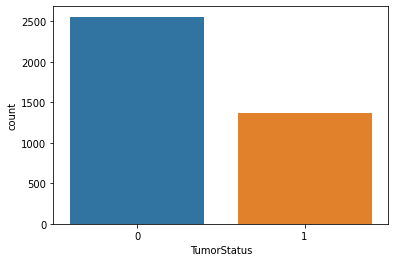

In [ ]:
sns.countplot(x=df['TumorStatus'])
plt.show()

In [ ]:
len(df[df['TumorStatus']==1])/len(df['TumorStatus'])

0.3494527869686943

Around 35% of the Images show the presence of tumor. So this is not a perfectly balanced dataset.

Now let us visualize some MR - Images and the corresponding masks.

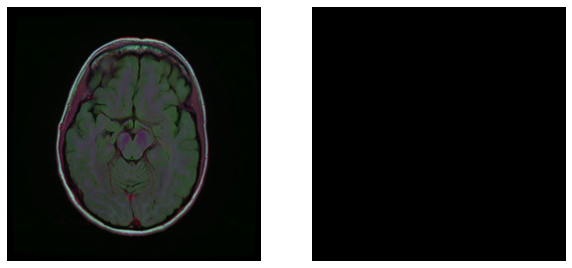

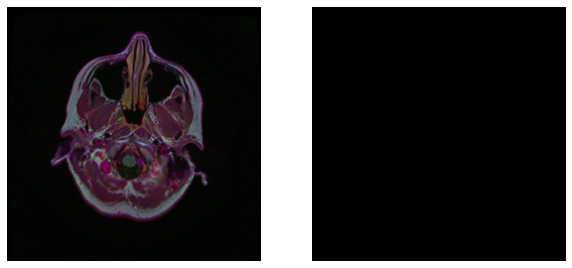

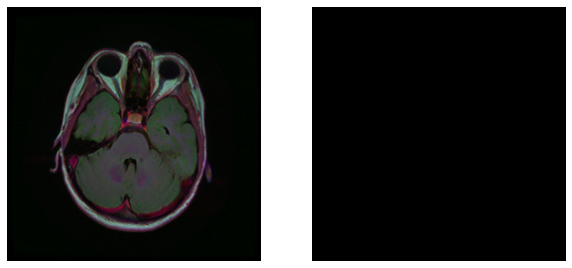

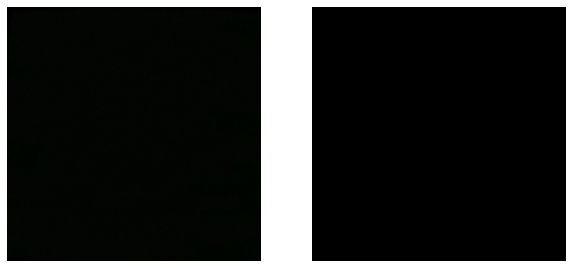

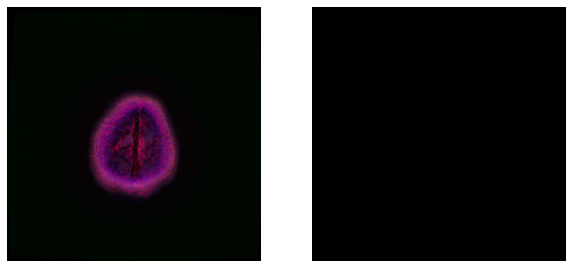

In [ ]:
# NO Tumor present
for i in range(5):
  plt.subplots(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.axis("off")
  img1 = (cv2.imread(df.loc[df[df['TumorStatus']==0].index[i]]['Image']))
  plt.imshow(img1)
  plt.subplot(1,2,2)
  plt.axis("off")
  img2 = (cv2.imread(df.loc[df[df['TumorStatus']==0].index[i]]['Mask']))
  plt.imshow(img2)
  plt.show()

The mask images are fully black and do not indicate presence of any tumor as expected.

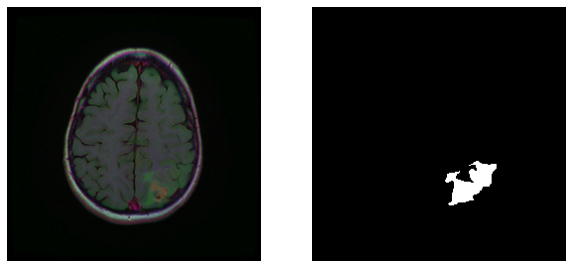

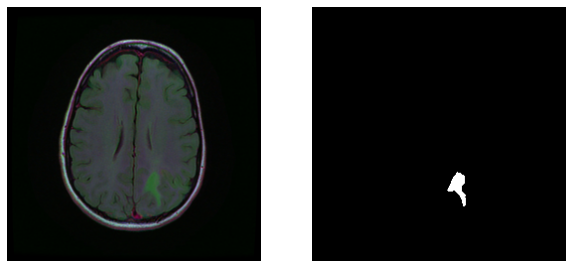

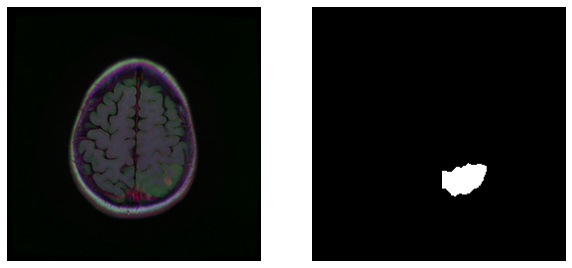

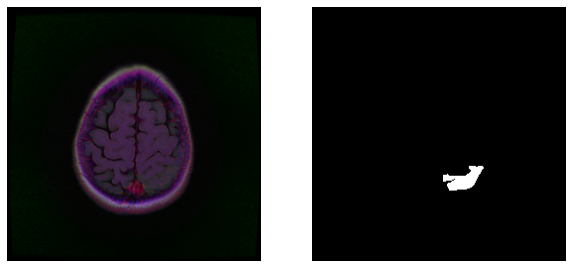

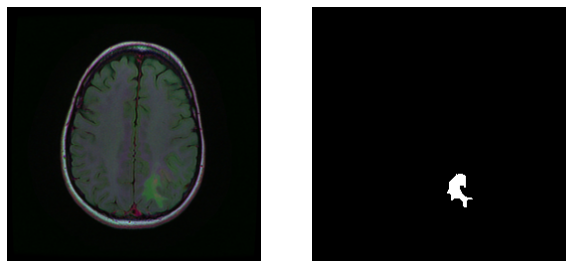

In [ ]:
# Tumor present
for i in range(5):
  plt.subplots(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.axis("off")
  img1 = (cv2.imread(df.loc[df[df['TumorStatus']==1].index[i]]['Image']))
  plt.imshow(img1)
  plt.subplot(1,2,2)
  plt.axis("off")
  img2 = (cv2.imread(df.loc[df[df['TumorStatus']==1].index[i]]['Mask']))
  plt.imshow(img2)
  plt.show()

We can clearly see the masks indicating the shape and location of the tumor. The test to our model would be how precisely it is able to get the finer details/ curves of the tumor shape.

## Image Augmentation

We will apply the following image augmentation techniques:
1. Rotation by a random angle.
2. Horizontal Flip
3. Vertical Flip
4. Sharpen
5. Blur

Let us visualize some of the Image Augmentation techniques for a sample Image.

In [ ]:
aug1 = iaa.Rotate((45,45))
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))
aug5 = iaa.MotionBlur()

In [ ]:
img1 = (cv2.imread(df.loc[df[df['TumorStatus']==1].index[2]]['Image']))
img2 = (cv2.imread(df.loc[df[df['TumorStatus']==1].index[2]]['Mask']))

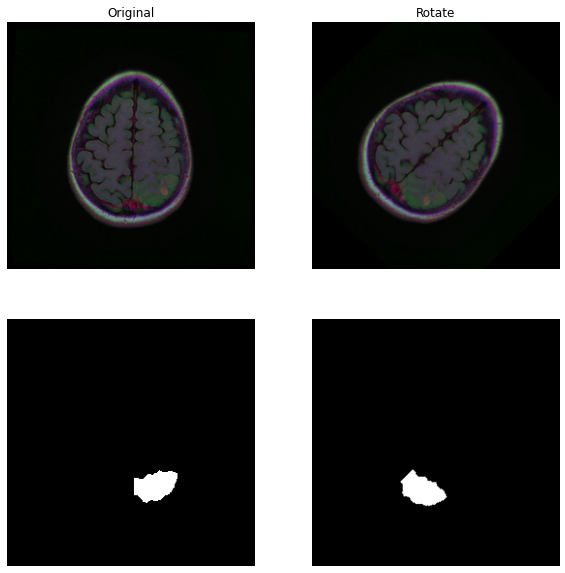

In [ ]:
plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(img1)
plt.title('Original')
plt.subplot(2,2,2)
plt.axis("off")
plt.imshow(aug1.augment_image(img1))
plt.title("Rotate")

plt.subplot(2,2,3)
plt.axis("off")
plt.imshow(img2)
plt.subplot(2,2,4)
plt.axis("off")
plt.imshow(aug1.augment_image(img2))
plt.show()

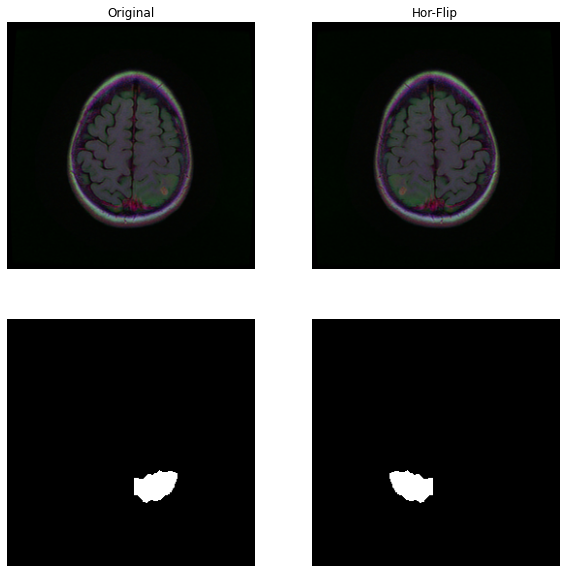

In [ ]:
plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(img1)
plt.title('Original')
plt.subplot(2,2,2)
plt.axis("off")
plt.imshow(aug2.augment_image(img1))
plt.title("Hor-Flip")

plt.subplot(2,2,3)
plt.axis("off")
plt.imshow(img2)
plt.subplot(2,2,4)
plt.axis("off")
plt.imshow(aug2.augment_image(img2))
plt.show()

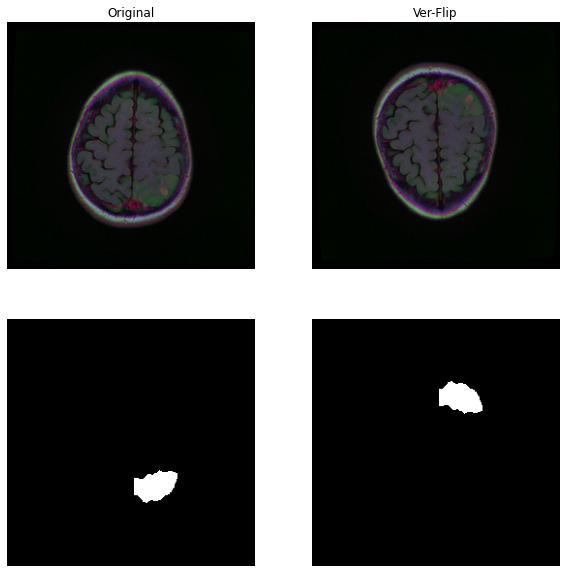

In [ ]:
plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(img1)
plt.title('Original')
plt.subplot(2,2,2)
plt.axis("off")
plt.imshow(aug3.augment_image(img1))
plt.title("Ver-Flip")

plt.subplot(2,2,3)
plt.axis("off")
plt.imshow(img2)
plt.subplot(2,2,4)
plt.axis("off")
plt.imshow(aug3.augment_image(img2))
plt.show()

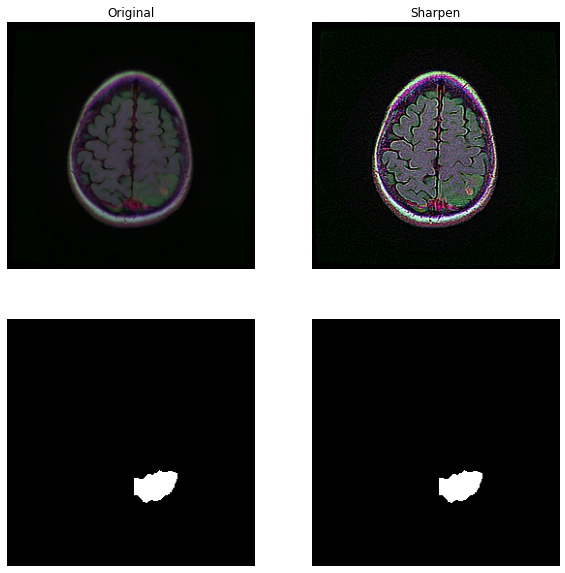

In [ ]:
plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(img1)
plt.title('Original')
plt.subplot(2,2,2)
plt.axis("off")
plt.imshow(aug4.augment_image(img1))
plt.title("Sharpen")

plt.subplot(2,2,3)
plt.axis("off")
plt.imshow(img2)
plt.subplot(2,2,4)
plt.axis("off")
plt.imshow(aug4.augment_image(img2))
plt.show()

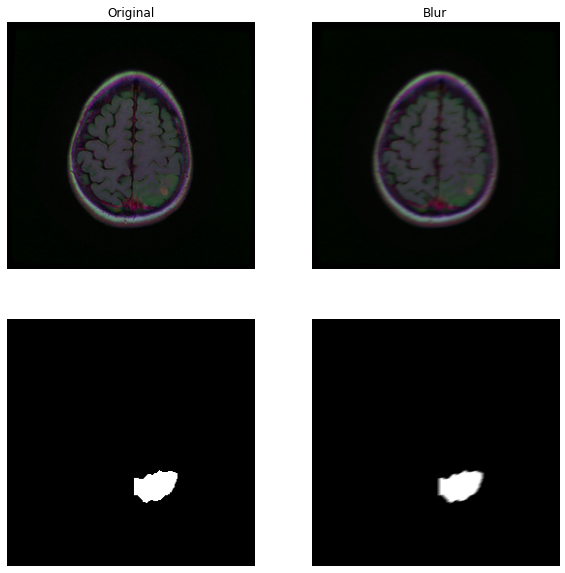

In [ ]:
plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.axis("off")
plt.imshow(img1)
plt.title('Original')
plt.subplot(2,2,2)
plt.axis("off")
plt.imshow(aug5.augment_image(img1))
plt.title("Blur")

plt.subplot(2,2,3)
plt.axis("off")
plt.imshow(img2)
plt.subplot(2,2,4)
plt.axis("off")
plt.imshow(aug5.augment_image(img2))
plt.show()

Now that we have visualized the augmented images. We can proceed with the preprocessing of the images in our dataset.

In [ ]:
# Create a copy of the original dataset
#shutil.rmtree('augmented_dataset')
'''
!mkdir augmented_dataset
dest_dir = path+'/augmented_dataset'
print(dest_dir)'''
shutil.copytree(path+'/lgg-mri-segmentation/kaggle_3m',path+'/augmented_dataset')
os.remove(path+'/augmented_dataset/README.md')
os.remove(path+'/augmented_dataset/data.csv')

# Verify copy
print(len(os.listdir(path+'/augmented_dataset')))
filesList = []
maskcount = 0
imagecount = 0
for p, subdirs, files in os.walk(path+'/augmented_dataset'):
    for name in files:
      filesList.append(os.path.join(p, name))

for f in filesList:
  if '_mask' in f:
    maskcount +=1
  else:
    imagecount +=1
print(len(filesList))
print(maskcount)
print(imagecount)    

110
7858
3929
3929


The original and the copied file counts match. Copy successful. Now let us update the path in the dataframe as well.

In [ ]:
df['Image'] = df['Image'].apply(lambda x: x.replace('lgg-mri-segmentation/kaggle_3m','augmented_dataset'))
df['Mask'] = df['Mask'].apply(lambda x: x.replace('lgg-mri-segmentation/kaggle_3m','augmented_dataset'))

In [ ]:
df.head()

,Image,Mask,TumorStatus
0,/content/augmented_dataset/TCGA_DU_A5TY_199707...,/content/augmented_dataset/TCGA_DU_A5TY_199707...,0
1,/content/augmented_dataset/TCGA_DU_A5TY_199707...,/content/augmented_dataset/TCGA_DU_A5TY_199707...,0
2,/content/augmented_dataset/TCGA_DU_A5TY_199707...,/content/augmented_dataset/TCGA_DU_A5TY_199707...,0
3,/content/augmented_dataset/TCGA_DU_A5TY_199707...,/content/augmented_dataset/TCGA_DU_A5TY_199707...,1
4,/content/augmented_dataset/TCGA_DU_A5TY_199707...,/content/augmented_dataset/TCGA_DU_A5TY_199707...,0


In [ ]:
def imageAugment(imagePath, maskPath):

  '''shutil.copy(imagePath, imagePath.replace(path+'/lgg-mri-segmentation/kaggle_3m', dest_dir))
  shutil.copy(maskPath, maskPath.replace(path+'/lgg-mri-segmentation/kaggle_3m', dest_dir))'''

  imageOrig = (cv2.imread(imagePath))
  maskOrig = (cv2.imread(maskPath))

  a = np.random.uniform()
  if a<0.2:
    angle = np.random.randint(0,360)
    aug1 = iaa.Rotate((angle,angle))
    imageAug = aug1.augment_image(imageOrig)
    maskAug = aug1.augment_image(maskOrig)
  elif a<0.4:
    imageAug = aug2.augment_image(imageOrig)
    maskAug = aug2.augment_image(maskOrig)
  elif a<0.6:
    imageAug = aug3.augment_image(imageOrig)
    maskAug = aug3.augment_image(maskOrig)    
  elif a<0.8:
    imageAug = aug4.augment_image(imageOrig)
    maskAug = aug4.augment_image(maskOrig)      
  else:
    imageAug = aug5.augment_image(imageOrig)
    maskAug = aug5.augment_image(maskOrig)  
  
  imagefile = imagePath[:-4]+'_aug.tif'
  maskfile = maskPath[:-4]+'_aug.tif'

  cv2.imwrite(imagefile, imageAug)    
  cv2.imwrite(maskfile, maskAug)

  return(imagefile,maskfile)

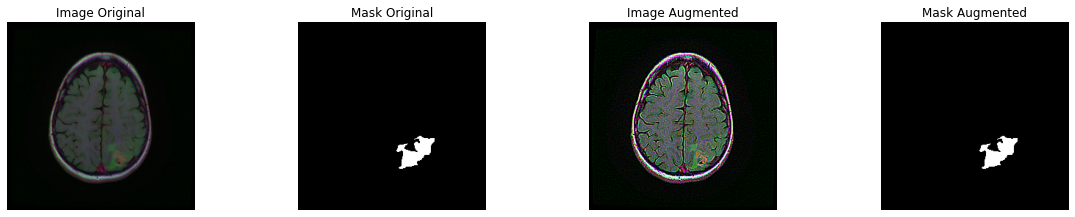

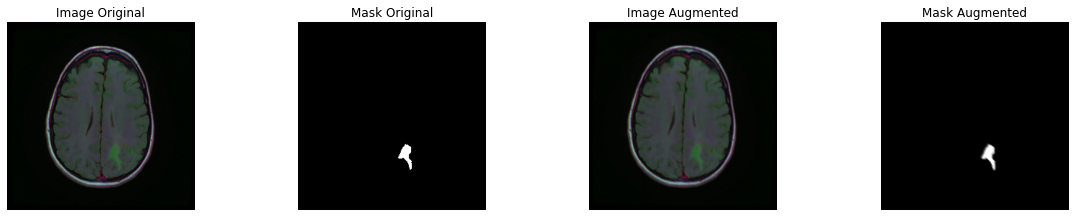

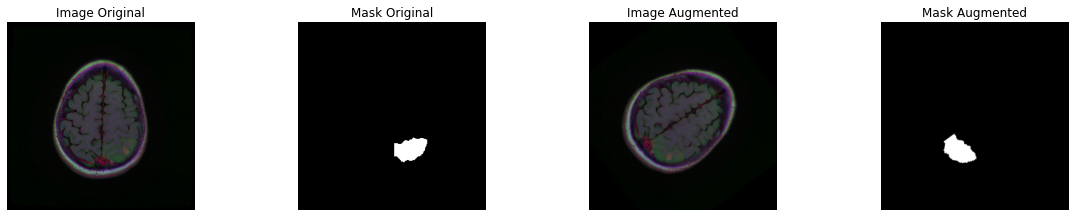

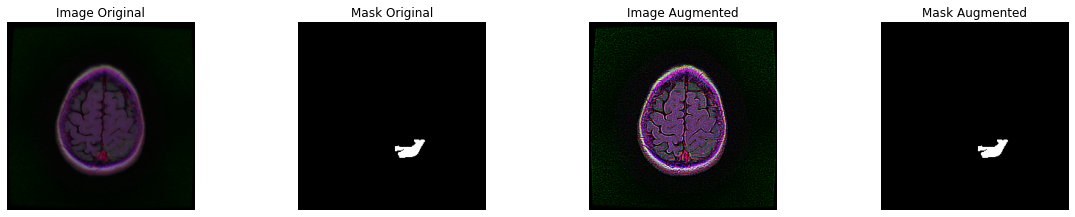

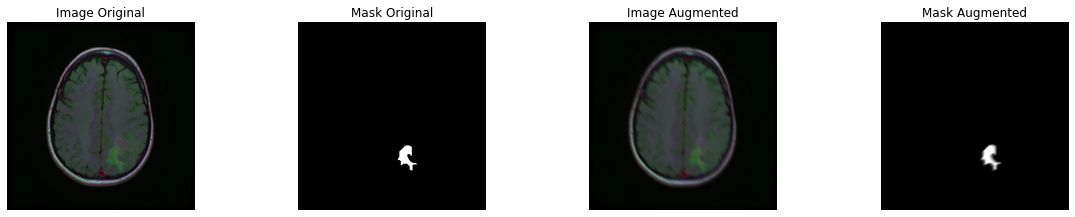

In [ ]:
def test_imageAugment():
  # unit test the image Augment function for 5 datapoints.
  for i in range(5):
    plt.subplots(figsize=(20,20))
    img1 = df.loc[df[df['TumorStatus']==1].index[i]]['Image']
    plt.subplot(5,4,i*4+1)
    plt.axis("off")
    plt.title('Image Original')
    plt.imshow(cv2.imread(img1))
    img2 = df.loc[df[df['TumorStatus']==1].index[i]]['Mask']
    plt.subplot(5,4,((i*2)+1)*2)
    plt.axis("off")
    plt.title('Mask Original')
    plt.imshow(cv2.imread(img2))
    ip, mp = imageAugment(img1, img2)
    plt.subplot(5,4,(((i*2)+1)*2)+1)
    plt.axis("off")
    plt.title('Image Augmented')
    plt.imshow(cv2.imread(ip))
    plt.subplot(5,4,(i+1)*4)
    plt.axis("off")
    plt.title('Mask Augmented')
    plt.imshow(cv2.imread(mp))
  
test_imageAugment()

Now let us augment the entire dataset.

In [ ]:
for index, row in df.iterrows():
  augimage, augmask = imageAugment(row['Image'], row['Mask'])
  df.loc[len(df.index)] = [augimage, augmask, row['TumorStatus']]

In [ ]:
df[df['Image'].str.contains('19980228_22')]

,Image,Mask,TumorStatus
501,/content/augmented_dataset/TCGA_DU_A5TW_199802...,/content/augmented_dataset/TCGA_DU_A5TW_199802...,1
4430,/content/augmented_dataset/TCGA_DU_A5TW_199802...,/content/augmented_dataset/TCGA_DU_A5TW_199802...,1


In [ ]:
# Verify augmentation
filesList = []
maskcount = 0
imagecount = 0
print(len(os.listdir(path+'/augmented_dataset')))
for p, subdirs, files in os.walk(path+'/augmented_dataset'):
    for name in files:
      filesList.append(os.path.join(p, name))

for f in filesList:
  if '_mask' in f:
    maskcount +=1
  else:
    imagecount +=1
print(len(filesList))
print(maskcount)
print(imagecount)     

110
15716
7858
7858


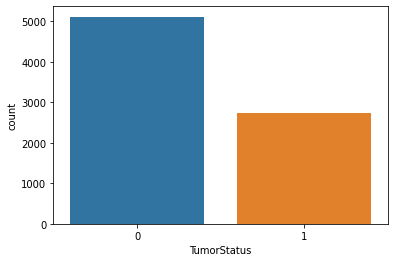

In [ ]:
sns.countplot(x=df['TumorStatus'])
plt.show()

In [ ]:
len(df[df['TumorStatus']==1])/len(df['TumorStatus'])

0.3494527869686943

The total number of images is doubled now with augmented images. we have preserved the class distribution as in the original dataset.

In [ ]:
def plotMetrics(modelName, hist, metricVal, lossVal):
  '''
  Plot Metrics and loss by epoch
  '''
  plt.figure(figsize=(10, 10)) 
  plt.subplot(211)
  plt.plot(hist.history[metricVal])
  plt.plot(hist.history['val_'+metricVal])
  plt.title(modelName+' '+metricVal)
  plt.xlabel('epoch')
  plt.ylabel(metricVal)
  plt.legend(['Train', 'Test'])
  #Plot Loss
  plt.subplot(212)
  plt.plot(hist.history[lossVal])
  plt.plot(hist.history['val_'+lossVal])
  plt.title(modelName+' '+lossVal)
  plt.xlabel('epoch')
  plt.ylabel(lossVal)
  plt.legend(['Train', 'Test'])
  plt.show()

In [ ]:
def modelSave(model,model_name):
  '''
  Save the model to a Json file
  '''
  model_json = model.to_json()
  with open(direc+"model_save/"+model_name+".json", "w") as jsonfile:
    jsonfile.write(model_json)

Continued in Part2...